In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np 

plt.rcParams["figure.figsize"] = [10, 7]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

data = pd.read_pickle('./data/scenario_3_alt.p')
data.head()

data['vacancy (for rent)'] = data['vacancy (for rent)'] * 100
data['vacancy (for sale)'] = data['vacancy (for sale)'] * 100
data['vacancy (off market)'] = data['vacancy (off market)'] * 100
data['vacancy total'] = data['vacancy total'] * 100
data['tax_rate_vacancy'] = data['tax_rate_vacancy'] * 100
data['central_bank_interest_rate'] = data['central_bank_interest_rate'] * 100


In [2]:
corr = np.corrcoef(data['central_bank_interest_rate'], data['vacancy total'])

corr_ = corr[0][1]

In [3]:
data[['vacancy (for rent)', 'vacancy (for sale)', 'vacancy (off market)', 'vacancy total']].describe().round(decimals=3)


vacancy (for rent)  vacancy (for sale)  vacancy (off market)  \
count             240.000             240.000               240.000   
mean                0.126              16.556                 4.948   
std                 0.300               1.726                 1.076   
min                 0.000              11.793                 2.451   
25%                 0.000              15.386                 4.197   
50%                 0.000              16.667                 4.947   
75%                 0.018              17.837                 5.643   
max                 1.493              20.214                 7.960   

       vacancy total  
count        240.000  
mean          21.630  
std            0.917  
min           18.648  
25%           20.928  
50%           21.651  
75%           22.370  
max           24.083

 
0.08027 x + 21.11


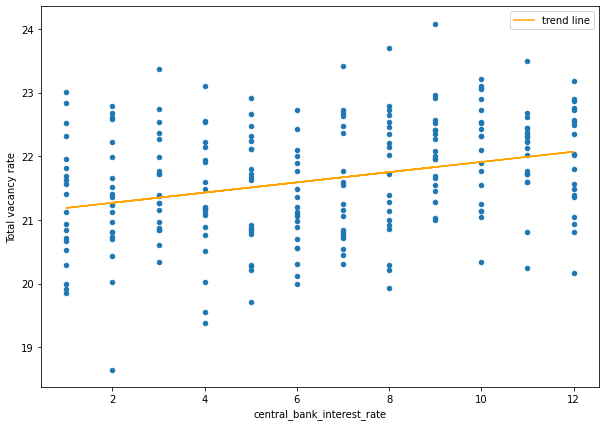

In [4]:
data.plot.scatter(x='central_bank_interest_rate', y='vacancy total', legend=True)

trend = np.polyfit(data['central_bank_interest_rate'], data['vacancy total'], 1)

trend_line = np.poly1d(trend)
print(trend_line)
plt.plot(data['central_bank_interest_rate'], trend_line(data['central_bank_interest_rate']), label='trend line', color='orange')

#plt.axhline(y=23, c='r', label='Initial vacancy rate')
plt.xlabel('central_bank_interest_rate')
plt.ylabel('Total vacancy rate')
plt.legend()


Text(0, 0.5, 'Total vacancy rate')

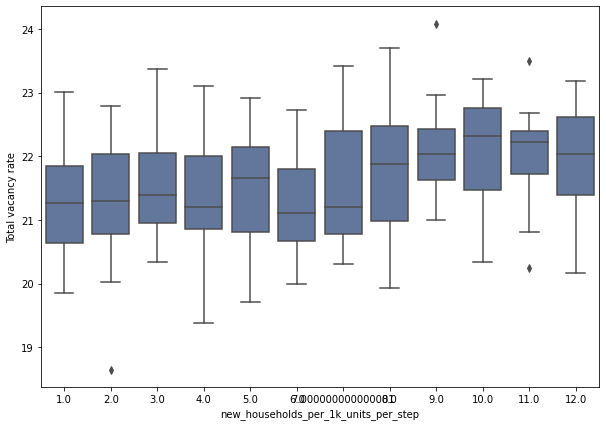

In [5]:
import seaborn as sns

ax = sns.boxplot(x='central_bank_interest_rate', y='vacancy total', data=data, color='#5975a4')

plt.xlabel('new_households_per_1k_units_per_step')
plt.ylabel('Total vacancy rate')


(0.5, 12.5)

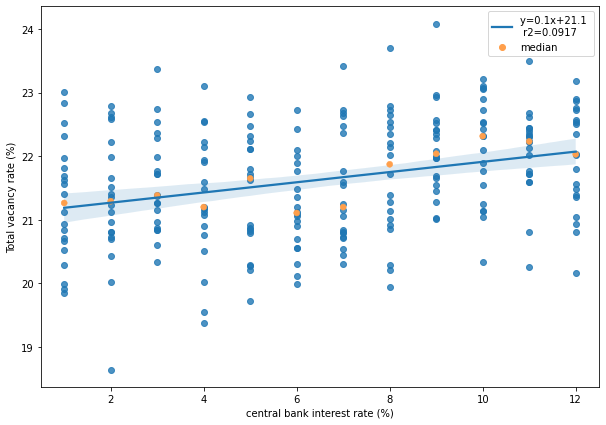

In [6]:
ax = sns.regplot(x='central_bank_interest_rate', y='vacancy total', data=data, line_kws={'label': 'y={1:.1f}x+{2:.1f} \n r2={0:.4f}'.format(corr_**2, *trend_line.coeffs)})

medians = data.groupby(['central_bank_interest_rate'])[['vacancy total']].apply(np.median)
med_df = pd.DataFrame(medians)
med_df.rename(columns = {0:'median'}, inplace = True) 
med_df.head()
m = sns.scatterplot(data=med_df, palette=['#ff9f4b'], marker="x")

plt.xlabel('central bank interest rate (%)')
plt.ylabel('Total vacancy rate (%)')
plt.legend()
plt.xlim(0.5, 12.5)

Text(0.5, 0, 'Vacancy rate (%)')

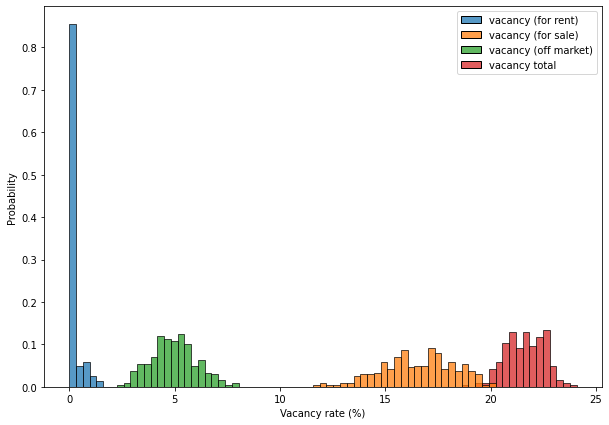

In [7]:
vacancy_df = data[['vacancy (for rent)', 'vacancy (for sale)', 'vacancy (off market)', 'vacancy total']]

vacancy_df.head()

sns.histplot(data=vacancy_df, bins=75, common_norm=False, stat='probability')

plt.xlabel('Vacancy rate (%)')
#plt.ylabel('Count')


In [8]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, parent_dir) 

from model import BSRIModel

from mesa.batchrunner import BatchRunner
from agents.investor import InvestorAgent


fixed_params = {
    "tax_rate_property": 0.01,
    "tax_rate_transfer": 0.01,
    "file": '../../neighbourhoods_clean.geojson',
    "new_households_per_1k_units_per_step": 9.5,
#    "central_bank_interest_rate": 0.1,
    "household_units_to_sample": 10,
    "tax_rate_property_vacant": 0.0,
    "tax_rate_vacancy": 0.02,
}
                                      
variable_params = {
    "central_bank_interest_rate": [2, 12],
}


model_reporters={
    "rental transactions": lambda model: model.transaction_count_rent_cumulative,
    "sale transactions": lambda model: model.transaction_count_sale_cumulative,
    "rentals": lambda model:  model.datacollector.get_table_dataframe('rentals'),
    "sales": lambda model:  model.datacollector.get_table_dataframe('sales'),
    "unhoused tenants": lambda model: len(model.households_without_homes),
    "vacancy total": lambda model: len(model.vacancies)/model.n_housing_units, 
    "vacancy (off market)": lambda model: len([unit for unit in model.vacancies if unit.on_market == 'no' and isinstance(unit.owner, InvestorAgent)])/model.n_housing_units, 
    "vacancy (for sale)": lambda model: len([unit for unit in model.vacancies if unit.on_market == 'sale'])/model.n_housing_units, 
    "vacancy (for rent)": lambda model: len([unit for unit in model.vacancies if unit.on_market == 'rent'])/model.n_housing_units, 
    "arrivals": lambda model: model.datacollector.get_table_dataframe('arrivals'), 
    "residents": lambda model: model.datacollector.get_table_dataframe('residents'), 
    "departures": lambda model: model.datacollector.get_table_dataframe('departures'), 
    "housing unit ownership": lambda model: model.datacollector.get_table_dataframe('housing unit ownership'),
    "neighbourhoods": lambda model: model.datacollector.get_table_dataframe('neighbourhoods')
}


batch_run = BatchRunner(BSRIModel,
                        variable_parameters=variable_params,
                        fixed_parameters=fixed_params,
                        iterations=1,
                        max_steps=20,
                        model_reporters=model_reporters)
batch_run.run_all()

0it [00:00, ?it/s]

>>>>> initialized with 5427 housing units


1it [00:54, 54.93s/it]

>>>>> -------------- SIMULATION COMPLETE AFTER 20 STEPS
>>>>> initialized with 5427 housing units


2it [01:45, 52.67s/it]

>>>>> -------------- SIMULATION COMPLETE AFTER 20 STEPS


In [9]:
data = batch_run.get_model_vars_dataframe()
data.head()

run_0 = data.iloc[0]
run_2 = data.iloc[1]

ownership_0 = gpd.GeoDataFrame(run_0['housing unit ownership'])
ownership_2 = gpd.GeoDataFrame(run_2['housing unit ownership'])


neighbourhoods_0 = gpd.GeoDataFrame(run_0['neighbourhoods'])
neighbourhoods_2 = gpd.GeoDataFrame(run_2['neighbourhoods'])

In [10]:
neighbourhoods_0['vacancy rate'] = neighbourhoods_0['vacancy rate'] * 100
neighbourhoods_2['vacancy rate'] = neighbourhoods_2['vacancy rate'] * 100

In [11]:
data.describe()

central_bank_interest_rate       Run  rental transactions  \
count                    2.000000  2.000000                  2.0   
mean                     7.000000  0.500000                  0.0   
std                      7.071068  0.707107                  0.0   
min                      2.000000  0.000000                  0.0   
25%                      4.500000  0.250000                  0.0   
50%                      7.000000  0.500000                  0.0   
75%                      9.500000  0.750000                  0.0   
max                     12.000000  1.000000                  0.0   

       sale transactions  unhoused tenants  vacancy (for rent)  \
count           2.000000          2.000000                 2.0   
mean          698.000000         97.500000                 0.0   
std             2.828427         12.020815                 0.0   
min           696.000000         89.000000                 0.0   
25%           697.000000         93.250000                 0.0   
50%           698.000000         97.500000                 0.0   
75%           699.000000        101.750000                 0.0   
max           700.000000        106.000000                 0.0   

       vacancy (for sale)  vacancy (off market)  vacancy total  \
count            2.000000              2.000000       2.000000   
mean             0.223512              0.006726       0.230238   
std              0.002345              0.001173       0.001173   
min              0.221854              0.005896       0.229409   
25%              0.222683              0.006311       0.229823   
50%              0.223512              0.006726       0.230238   
75%              0.224341              0.007140       0.230652   
max              0.225170              0.007555       0.231067   

       tax_rate_property  tax_rate_transfer  \
count               2.00               2.00   
mean                0.01               0.01   
std                 0.00               0.00   
min                 0.01               0.01   
25%                 0.01               0.01   
50%                 0.01               0.01   
75%                 0.01               0.01   
max                 0.01               0.01   

       new_households_per_1k_units_per_step  household_units_to_sample  \
count                                   2.0                        2.0   
mean                                    9.5                       10.0   
std                                     0.0                        0.0   
min                                     9.5                       10.0   
25%                                     9.5                       10.0   
50%                                     9.5                       10.0   
75%                                     9.5                       10.0   
max                                     9.5                       10.0   

       tax_rate_property_vacant  tax_rate_vacancy  
count                       2.0              2.00  
mean                        0.0              0.02  
std                         0.0              0.00  
min                         0.0              0.02  
25%                         0.0              0.02  
50%                         0.0              0.02  
75%                         0.0              0.02  
max                         0.0              0.02

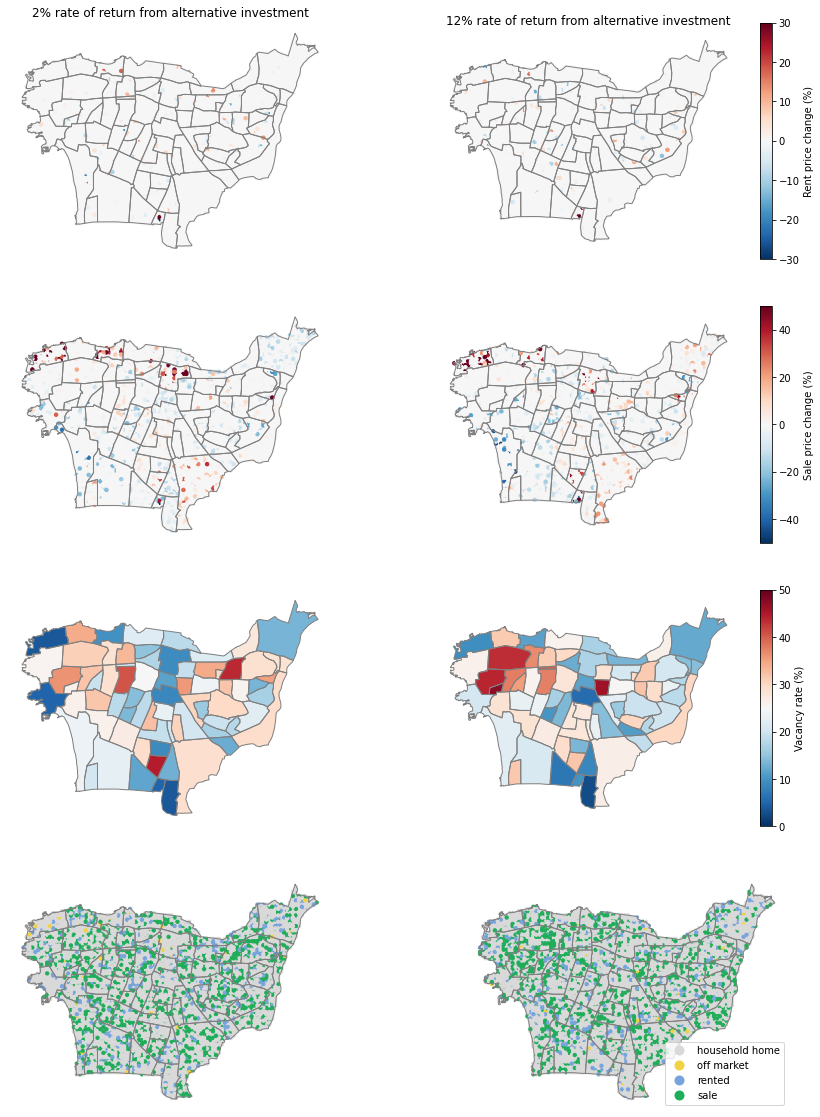

In [20]:
boundaries = gpd.read_file('../../neighbourhoods_clean.geojson')


fig, axs = plt.subplots(4, 2, figsize=(15, 20))

legend = ListedColormap(['#d9d9d9', # grey 
                         '#f1d341', # yellow
                         '#78a4de', # light blue 
                         '#1fad5a', # green
#                         '#1f5cad', # blue
                        ])

# add titles
axs[0, 0].set_title('2% rate of return from alternative investment')
axs[0, 1].set_title('12% rate of return from alternative investment')

## with 0% vacancy tax
ownership_0.plot(column='rent delta', 
                 ax=axs[0, 0],
                 legend=False,
                 cmap='RdBu_r', 
                 marker='o',
                 markersize=12,
                 legend_kwds={'label': "Rent price change (%)",},
                 vmin=-30,
                 vmax=30,
)

ownership_0.plot(column='sale delta', 
                 ax=axs[1, 0],
                 legend=False,
                 cmap='RdBu_r', 
                 marker='o',
                 markersize=12,
                 legend_kwds={'label': "Sale price change (%)",},
                 vmin=-50,
                 vmax=50,
)
neighbourhoods_0.plot(column='vacancy rate',
                      ax=axs[2, 0],
                      legend=False,
                      cmap='RdBu_r', 
                      legend_kwds={'label': "Vacancy rate (%)",},
                      vmin=0,
                      vmax=50,
)

ownership_0.plot(column='legend', 
                 ax=axs[3, 0],
                 legend=False,
                 cmap=legend,
                 marker='o',
                 markersize=11,)


### with 2% vacancy tax
ownership_2.plot(column='rent delta', 
                 ax=axs[0, 1],
                 legend=True,
                 cmap='RdBu_r', 
                 marker='o',
                 markersize=12,
                 legend_kwds={'label': "Rent price change (%)",},
                 vmin=-30,
                 vmax=30,
)

ownership_2.plot(column='sale delta', 
                 ax=axs[1, 1],
                 legend=True,
                 cmap='RdBu_r', 
                 marker='o',
                 markersize=12,
                 legend_kwds={'label': "Sale price change (%)",},
                 vmin=-50,
                 vmax=50,
)
neighbourhoods_2.plot(column='vacancy rate',
                      ax=axs[2, 1],
                      legend=True,
                      cmap='RdBu_r', 
                      legend_kwds={'label': "Vacancy rate (%)",},
                      vmin=0,
                      vmax=50,
)
ownership_2.plot(column='legend', 
                 ax=axs[3, 1],
                 legend=True,
                 cmap=legend,
                 marker='o',
                 markersize=11,)


for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set(frame_on=False)
        boundaries.plot(ax=ax, facecolor="none", edgecolor="#808080")


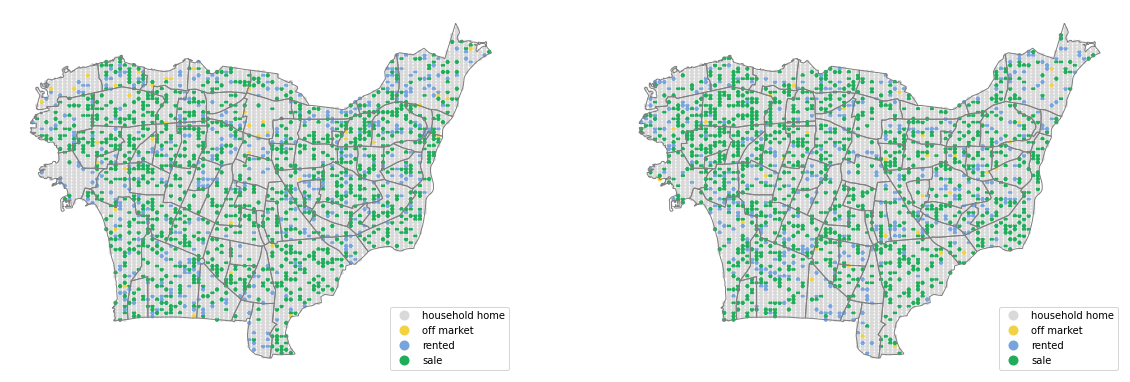

In [13]:
from matplotlib.colors import ListedColormap

legend = ListedColormap(['#d9d9d9', # grey 
                         '#f1d341', # yellow
                         '#78a4de', # light blue 
                         '#1fad5a', # green
#                         '#1f5cad', # blue
                        ])
fig, axs = plt.subplots(1, 2, figsize=(20, 7))



ownership_0.plot(column='legend', 
                 ax=axs[0],
                 legend=True,
                 cmap=legend,
                 marker='o',
                 markersize=11,)

ownership_2.plot(column='legend', 
                 ax=axs[1],
                 legend=True,
                 cmap=legend,
                 marker='o',
                 markersize=11,)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(frame_on=False)
    boundaries.plot(ax=ax, facecolor="none", edgecolor="#808080")
